# Prevendo o Nível de Satisfação dos Clientes do Santander

### Definição Problema de Negócio

Satisfasção de clientes é a chave para o sucesso e o Santander criou o dataset `santander-customer-satisfaction` e através da comunidade do [kaggle](https://www.kaggle.com/c/santander-customer-satisfaction/overview) lançou o desafio para identificar quais os clientes estão satisfeistos. 

Uma caracteristica interessante deste desafio é que os nomes das variáveis são anônimos, não sendo possível identifica-los, tornando a exploração dos dados parte importante do processo.

O método de avaliação para o desafio é ROC, mais detalhes sobre a merica no brilhante  artigo escrito por Sarang Narkhede [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) 

## Metodologia e Tools

Este desafio foi proposto como projeto de conclusão do curso de [Big Data Real-Time Analytics com Python e Spark](https://www.datascienceacademy.com.br/course?courseid=analise-de-dados-com-python) da Data Science Academy, sendo assim o trabalho foi todo conduzido com pyspark.

Como se trata de um problema de classificação a solução de modelagem foi avaliada em 5 tipos de algoritmos, dentre eles LogisticRegression, DecisionTreeClassifier e GBTClassifier da biblioteca [MLlib](https://spark.apache.org/docs/latest/ml-classification-regression.html)

## Etapas

1. Coleta dos dados utilizando [kaggle API](https://www.kaggle.com/docs/api) 

2. Importanção dos dados para um DataFrame do Spark

3. Exploração do dataset
    -  Analise do schema


4. Data Clean

    - Analise de nulos
    - Analise Target
    - Analise de varíaveis isoladamente var3, var15, var38, etc
    
    
5. Criação do pipeline para preparação do dataset para etapa de Machine Learning

    - Index
    - VectorAssembler
    
    
6. Seleção de variáveis utilizando chisquareSelector


7. Modelagem (ROC - Test set) 

    - Logistic Regression  
    
    - Decision Tree 
    
    - Gradient Boost Tree
    
    - Random Forest
    
    - Linear SVC

### Imports

In [20]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline



import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook


### Coleta de Dados

In [ ]:
!pip install kaggle

In [ ]:
! kaggle competitions list -s santander-customer-satisfaction

In [ ]:
!kaggle competitions download -c santander-customer-satisfaction

In [ ]:
!ls /home/bruno/Dropbox/Cursos/DSA/FCD/BigDataRealTimePythonSpark/Projeto3

In [ ]:
path = '/home/bruno/Dropbox/Cursos/DSA/FCD/BigDataRealTimePythonSpark/Projeto3'


In [ ]:
! unzip $path/'santander-customer-satisfaction.zip'

In [ ]:
! ls $path

### Data Import

In [2]:
spSession = SparkSession.builder.master('local').appName('P3').getOrCreate()




In [3]:
# Carregando dados e gerando um DataFrame
train = '/home/bruno/Dropbox/Cursos/DSA/FCD/BigDataRealTimePythonSpark/Projeto3/train.csv'

df = spark \
        .read \
        .csv(train, header=True , inferSchema=True)




In [4]:
df.count()

76020

In [5]:
print(len(df.columns))

371


In [ ]:
test = '/home/bruno/Dropbox/Cursos/DSA/FCD/BigDataRealTimePythonSpark/Projeto3/test.csv'

test_df = spark \
        .read \
        .csv(test, header=True , inferSchema=True)

In [6]:

df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- var3: integer (nullable = true)
 |-- var15: integer (nullable = true)
 |-- imp_ent_var16_ult1: double (nullable = true)
 |-- imp_op_var39_comer_ult1: double (nullable = true)
 |-- imp_op_var39_comer_ult3: double (nullable = true)
 |-- imp_op_var40_comer_ult1: double (nullable = true)
 |-- imp_op_var40_comer_ult3: double (nullable = true)
 |-- imp_op_var40_efect_ult1: double (nullable = true)
 |-- imp_op_var40_efect_ult3: double (nullable = true)
 |-- imp_op_var40_ult1: double (nullable = true)
 |-- imp_op_var41_comer_ult1: double (nullable = true)
 |-- imp_op_var41_comer_ult3: double (nullable = true)
 |-- imp_op_var41_efect_ult1: double (nullable = true)
 |-- imp_op_var41_efect_ult3: double (nullable = true)
 |-- imp_op_var41_ult1: double (nullable = true)
 |-- imp_op_var39_efect_ult1: double (nullable = true)
 |-- imp_op_var39_efect_ult3: double (nullable = true)
 |-- imp_op_var39_ult1: double (nullable = true)
 |-- imp_sal_var16_ult1: dou

## EDA

#### Check Nulls

In [ ]:
for col in df.columns:
    print(col, '\t', 'with null values: ', df.filter(df[col].isNull()).count())

#### Visualizando as 5 primeiras linhas

In [7]:
df.limit(5).toPandas()


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

#### TARGET

In [8]:
df.groupBy('TARGET').count().show()

+------+-----+
|TARGET|count|
+------+-----+
|     1| 3008|
|     0|73012|
+------+-----+



Variável `TARGET` tem muitos valores `0` 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f654dc2f6d8>]],
      dtype=object)

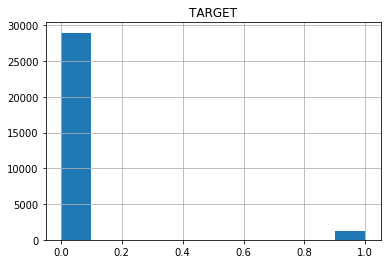

In [13]:
df.select('TARGET').sample(fraction=0.4).toPandas().hist(bins=10)


#### VAR3

In [14]:
df.describe(['var3']).show()

+-------+-------------------+
|summary|               var3|
+-------+-------------------+
|  count|              76020|
|   mean|-1523.1992765061825|
| stddev|  39033.46236386329|
|    min|            -999999|
|    max|                238|
+-------+-------------------+



In [15]:
df.groupBy('var3').count().sort('var3').show(10)


+-------+-----+
|   var3|count|
+-------+-----+
|-999999|  116|
|      0|   75|
|      1|  105|
|      2|74165|
|      3|  108|
|      4|   86|
|      5|   63|
|      6|   82|
|      7|   97|
|      8|  138|
+-------+-----+
only showing top 10 rows



Replace **var3** `-99999` pelo valor mais frequente `2`

In [16]:
from pyspark.sql.functions import when

df = df.withColumn("var3", \
              when(df["var3"] == -999999, 2).otherwise(df["var3"]))

In [17]:
df.groupBy('var3').count().sort('var3').show(10)


+----+-----+
|var3|count|
+----+-----+
|   0|   75|
|   1|  105|
|   2|74281|
|   3|  108|
|   4|   86|
|   5|   63|
|   6|   82|
|   7|   97|
|   8|  138|
|   9|  110|
+----+-----+
only showing top 10 rows



In [18]:
df.describe(['var3']).show()

+-------+------------------+
|summary|              var3|
+-------+------------------+
|  count|             76020|
|   mean|2.7164825046040515|
| stddev| 9.447971328015095|
|    min|                 0|
|    max|               238|
+-------+------------------+



<IPython.core.display.Javascript object>


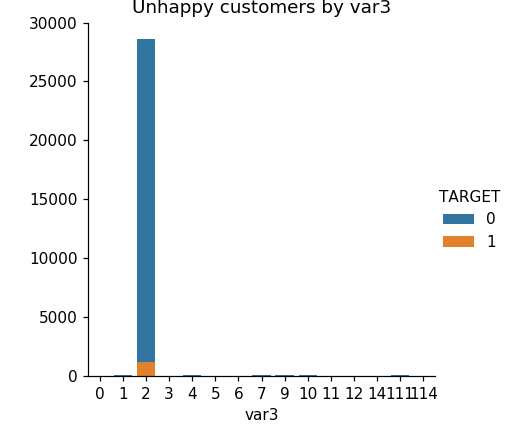

In [22]:
g1 = df.select('var3', 'TARGET').sample(fraction=0.4).toPandas()

sns.FacetGrid(g1, hue="TARGET", size=4) \
  .map(sns.countplot, "var3") \
  .add_legend()
plt.title('Unhappy customers by var3');


#### VAR15

In [23]:
df.describe(['var15']).show()

+-------+------------------+
|summary|             var15|
+-------+------------------+
|  count|             76020|
|   mean| 33.21286503551697|
| stddev|12.956485816411224|
|    min|                 5|
|    max|               105|
+-------+------------------+



<IPython.core.display.Javascript object>


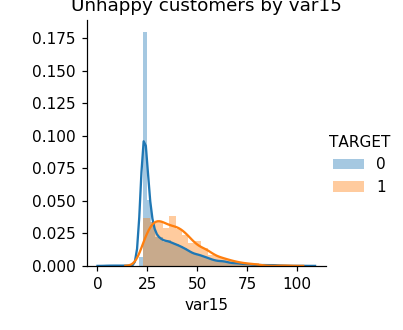

In [26]:
g2 = df.select('var15', 'TARGET').sample(fraction=0.4).toPandas()

sns.FacetGrid(g2, hue="TARGET", size=3) \
  .map(sns.distplot, "var15") \
  .add_legend()
plt.title('Unhappy customers by var15');


#### VAR38

In [27]:
df.describe(['var38']).show()

+-------+------------------+
|summary|             var38|
+-------+------------------+
|  count|             76020|
|   mean|117235.80943038077|
| stddev|182664.59850287274|
|    min|           5163.75|
|    max|     2.203473876E7|
+-------+------------------+



<IPython.core.display.Javascript object>


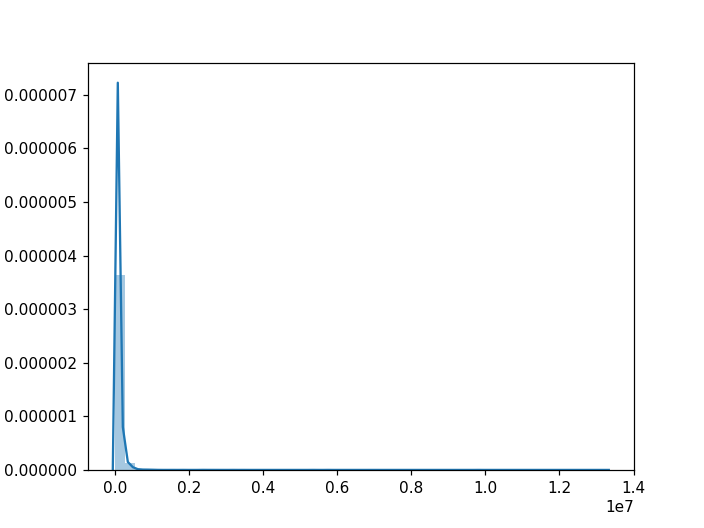

In [28]:
g3 = df.select('var38').sample(fraction=0.4).toPandas()

sns.distplot(g3)

# sns.FacetGrid(g3, hue="TARGET", size=6) \
#   .map(sns.distplot, "var38") \
#   .add_legend()
# plt.title('Unhappy customers by var38');

#### Cols

In [29]:
df.dtypes

[('ID', 'int'),
 ('var3', 'int'),
 ('var15', 'int'),
 ('imp_ent_var16_ult1', 'double'),
 ('imp_op_var39_comer_ult1', 'double'),
 ('imp_op_var39_comer_ult3', 'double'),
 ('imp_op_var40_comer_ult1', 'double'),
 ('imp_op_var40_comer_ult3', 'double'),
 ('imp_op_var40_efect_ult1', 'double'),
 ('imp_op_var40_efect_ult3', 'double'),
 ('imp_op_var40_ult1', 'double'),
 ('imp_op_var41_comer_ult1', 'double'),
 ('imp_op_var41_comer_ult3', 'double'),
 ('imp_op_var41_efect_ult1', 'double'),
 ('imp_op_var41_efect_ult3', 'double'),
 ('imp_op_var41_ult1', 'double'),
 ('imp_op_var39_efect_ult1', 'double'),
 ('imp_op_var39_efect_ult3', 'double'),
 ('imp_op_var39_ult1', 'double'),
 ('imp_sal_var16_ult1', 'double'),
 ('ind_var1_0', 'int'),
 ('ind_var1', 'int'),
 ('ind_var2_0', 'int'),
 ('ind_var2', 'int'),
 ('ind_var5_0', 'int'),
 ('ind_var5', 'int'),
 ('ind_var6_0', 'int'),
 ('ind_var6', 'int'),
 ('ind_var8_0', 'int'),
 ('ind_var8', 'int'),
 ('ind_var12_0', 'int'),
 ('ind_var12', 'int'),
 ('ind_var13_0', 

In [30]:
for col in df.columns:
    df.describe(col).show()

+-------+------------------+
|summary|                ID|
+-------+------------------+
|  count|             76020|
|   mean| 75964.05072349381|
| stddev|43781.947379493686|
|    min|                 1|
|    max|            151838|
+-------+------------------+

+-------+------------------+
|summary|              var3|
+-------+------------------+
|  count|             76020|
|   mean|2.7164825046040515|
| stddev| 9.447971328015095|
|    min|                 0|
|    max|               238|
+-------+------------------+

+-------+------------------+
|summary|             var15|
+-------+------------------+
|  count|             76020|
|   mean| 33.21286503551697|
| stddev|12.956485816411224|
|    min|                 5|
|    max|               105|
+-------+------------------+

+-------+------------------+
|summary|imp_ent_var16_ult1|
+-------+------------------+
|  count|             76020|
|   mean| 86.20826519337015|
| stddev|1614.7573127238225|
|    min|               0.0|
|    max|  

+-------+-------------------+
|summary|        ind_var12_0|
+-------+-------------------+
|  count|              76020|
|   mean|0.06752170481452249|
| stddev|0.25092499365481086|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

+-------+--------------------+
|summary|           ind_var12|
+-------+--------------------+
|  count|               76020|
|   mean|0.045461720599842145|
| stddev| 0.20831592210738728|
|    min|                   0|
|    max|                   1|
+-------+--------------------+

+-------+-------------------+
|summary|        ind_var13_0|
+-------+-------------------+
|  count|              76020|
|   mean|0.05224940805051302|
| stddev|0.22253102888627022|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

+-------+-------------------+
|summary|  ind_var13_corto_0|
+-------+-------------------+
|  count|              76020|
|   mean|0.04293606945540647|
| stddev|0.20271434076456318

+-------+--------------------+
|summary|         ind_var29_0|
+-------+--------------------+
|  count|               76020|
|   mean|1.052354643514864...|
| stddev|0.010257961495049994|
|    min|                   0|
|    max|                   1|
+-------+--------------------+

+-------+--------------------+
|summary|           ind_var29|
+-------+--------------------+
|  count|               76020|
|   mean|2.630886608787161...|
| stddev|0.005129183171334561|
|    min|                   0|
|    max|                   1|
+-------+--------------------+

+-------+-------------------+
|summary|        ind_var30_0|
+-------+-------------------+
|  count|              76020|
|   mean| 0.9954880294659301|
| stddev|0.06701993540257138|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

+-------+-------------------+
|summary|          ind_var30|
+-------+-------------------+
|  count|              76020|
|   mean| 0.7328334648776638|
| stddev|0.44248294

+-------+--------------------+
|summary|          num_var6_0|
+-------+--------------------+
|  count|               76020|
|   mean|3.157063930544593...|
| stddev|0.030773884485149963|
|    min|                   0|
|    max|                   3|
+-------+--------------------+

+-------+--------------------+
|summary|            num_var6|
+-------+--------------------+
|  count|               76020|
|   mean|7.892659826361483E-5|
| stddev|0.015387549514003732|
|    min|                   0|
|    max|                   3|
+-------+--------------------+

+-------+-------------------+
|summary|         num_var8_0|
+-------+-------------------+
|  count|              76020|
|   mean|0.09853985793212312|
| stddev|  0.534929915158125|
|    min|                  0|
|    max|                  6|
+-------+-------------------+

+-------+-------------------+
|summary|           num_var8|
+-------+-------------------+
|  count|              76020|
|   mean|0.08579321231254933|
| stddev| 0.5000224

+-------+-------------------+
|summary|  num_op_var40_ult1|
+-------+-------------------+
|  count|              76020|
|   mean|0.05702446724546172|
| stddev| 1.8273735550842103|
|    min|                  0|
|    max|                234|
+-------+-------------------+

+-------+-------------------+
|summary|  num_op_var40_ult3|
+-------+-------------------+
|  count|              76020|
|   mean|0.07829518547750591|
| stddev| 2.5582159751668225|
|    min|                  0|
|    max|                351|
+-------+-------------------+

+-------+------------------+
|summary|num_op_var41_hace2|
+-------+------------------+
|  count|             76020|
|   mean|1.6011444356748223|
| stddev| 7.322004216980757|
|    min|                 0|
|    max|               249|
+-------+------------------+

+-------+-------------------+
|summary| num_op_var41_hace3|
+-------+-------------------+
|  count|              76020|
|   mean|0.09392265193370165|
| stddev| 1.2152178380184733|
|    min|       

+-------+--------------------+
|summary|           num_var40|
+-------+--------------------+
|  count|               76020|
|   mean|0.011168113654301499|
| stddev| 0.18270208892069406|
|    min|                   0|
|    max|                   3|
+-------+--------------------+

+-------+------------------+
|summary|       num_var41_0|
+-------+------------------+
|  count|             76020|
|   mean|2.6992501973164957|
| stddev|1.1052967291810671|
|    min|                 0|
|    max|                33|
+-------+------------------+

+-------+---------+
|summary|num_var41|
+-------+---------+
|  count|    76020|
|   mean|      0.0|
| stddev|      0.0|
|    min|        0|
|    max|        0|
+-------+---------+

+-------+--------------------+
|summary|           num_var39|
+-------+--------------------+
|  count|               76020|
|   mean|0.011168113654301499|
| stddev| 0.18270208892069406|
|    min|                   0|
|    max|                   3|
+-------+--------------------

+-------+------------------+
|summary|       saldo_var34|
+-------+------------------+
|  count|             76020|
|   mean|0.6708760852407262|
| stddev|141.44859764285619|
|    min|                 0|
|    max|             36000|
+-------+------------------+

+-------+------------------+
|summary|       saldo_var37|
+-------+------------------+
|  count|             76020|
|   mean| 36.90719376479875|
| stddev|472.09886294830284|
|    min|               0.0|
|    max|           60000.0|
+-------+------------------+

+-------+------------------+
|summary|       saldo_var40|
+-------+------------------+
|  count|             76020|
|   mean|  4.36860181531176|
| stddev|113.96875632397456|
|    min|              -0.9|
|    max|           8192.61|
+-------+------------------+

+-------+-----------+
|summary|saldo_var41|
+-------+-----------+
|  count|      76020|
|   mean|        0.0|
| stddev|        0.0|
|    min|          0|
|    max|          0|
+-------+-----------+

+-------+------

+-------+-------------------------+
|summary|delta_num_reemb_var17_1y3|
+-------+-------------------------+
|  count|                    76020|
|   mean|        2630886.608510918|
| stddev|     1.6217980919332236E8|
|    min|                       -1|
|    max|               9999999999|
+-------+-------------------------+

+-------+-------------------------+
|summary|delta_num_reemb_var33_1y3|
+-------+-------------------------+
|  count|                    76020|
|   mean|       131544.33042620364|
| stddev|      3.626904057361448E7|
|    min|                        0|
|    max|               9999999999|
+-------+-------------------------+

+-------+----------------------------+
|summary|delta_num_trasp_var17_in_1y3|
+-------+----------------------------+
|  count|                       76020|
|   mean|           526177.3216785056|
| stddev|           7.2536649818282E7|
|    min|                          -1|
|    max|                  9999999999|
+-------+----------------------------+

+-------+--------------------+
|summary|imp_trans_var37_ult1|
+-------+--------------------+
|  count|               76020|
|   mean|  1932.9544317284929|
| stddev|   25355.71742923688|
|    min|                 0.0|
|    max|           2310003.0|
+-------+--------------------+

+-------+------------------------+
|summary|imp_trasp_var17_in_hace3|
+-------+------------------------+
|  count|                   76020|
|   mean|      1.8748082083662196|
| stddev|       388.2450217964926|
|    min|                     0.0|
|    max|                96781.44|
+-------+------------------------+

+-------+-----------------------+
|summary|imp_trasp_var17_in_ult1|
+-------+-----------------------+
|  count|                  76020|
|   mean|     2.5126783741120757|
| stddev|      508.9688306435794|
|    min|                    0.0|
|    max|              133730.58|
+-------+-----------------------+

+-------+-------------------------+
|summary|imp_trasp_var17_out_hace3|
+-------+----------------

+-------+--------------------+
|summary| num_var7_recib_ult1|
+-------+--------------------+
|  count|               76020|
|   mean|0.010299921073401736|
| stddev| 0.22878226481199293|
|    min|                   0|
|    max|                  24|
+-------+--------------------+

+-------+----------------------+
|summary|num_compra_var44_hace3|
+-------+----------------------+
|  count|                 76020|
|   mean|  0.001854775059194...|
| stddev|   0.09911130364373212|
|    min|                     0|
|    max|                     9|
+-------+----------------------+

+-------+---------------------+
|summary|num_compra_var44_ult1|
+-------+---------------------+
|  count|                76020|
|   mean| 0.007537490134175217|
| stddev|   0.3154526889327579|
|    min|                    0|
|    max|                   39|
+-------+---------------------+

+-------+-------------------+
|summary| num_ent_var16_ult1|
+-------+-------------------+
|  count|              76020|
|   mean|0.18

+-------+-----------------------+
|summary|num_op_var41_efect_ult1|
+-------+-----------------------+
|  count|                  76020|
|   mean|     0.7194159431728493|
| stddev|      3.210999275224297|
|    min|                      0|
|    max|                     90|
+-------+-----------------------+

+-------+-----------------------+
|summary|num_op_var41_efect_ult3|
+-------+-----------------------+
|  count|                  76020|
|   mean|     1.2121546961325966|
| stddev|      5.160396257938066|
|    min|                      0|
|    max|                    156|
+-------+-----------------------+

+-------+-----------------------+
|summary|num_op_var39_efect_ult1|
+-------+-----------------------+
|  count|                  76020|
|   mean|     0.7219021310181531|
| stddev|     3.2263144199442677|
|    min|                      0|
|    max|                     90|
+-------+-----------------------+

+-------+-----------------------+
|summary|num_op_var39_efect_ult3|
+-------+--

+-------+----------------------+
|summary|saldo_medio_var5_hace2|
+-------+----------------------+
|  count|                 76020|
|   mean|    1579.1353113654288|
| stddev|    12148.452398418292|
|    min|               -128.37|
|    max|             812137.26|
+-------+----------------------+

+-------+----------------------+
|summary|saldo_medio_var5_hace3|
+-------+----------------------+
|  count|                 76020|
|   mean|     891.3658634569844|
| stddev|      9888.59699974839|
|    min|                 -8.04|
|    max|            1542339.36|
+-------+----------------------+

+-------+---------------------+
|summary|saldo_medio_var5_ult1|
+-------+---------------------+
|  count|                76020|
|   mean|   1077.2567557221778|
| stddev|    9614.906985285334|
|    min|              -922.38|
|    max|             601428.6|
+-------+---------------------+

+-------+---------------------+
|summary|saldo_medio_var5_ult3|
+-------+---------------------+
|  count|          

+-------+----------------------+
|summary|saldo_medio_var17_ult1|
+-------+----------------------+
|  count|                 76020|
|   mean|    131.03156590370955|
| stddev|    14956.526225630745|
|    min|                   0.0|
|    max|            3998687.46|
+-------+----------------------+

+-------+----------------------+
|summary|saldo_medio_var17_ult3|
+-------+----------------------+
|  count|                 76020|
|   mean|    109.21694356748223|
| stddev|    13082.157458258936|
|    min|                   0.0|
|    max|            3525776.88|
+-------+----------------------+

+-------+-----------------------+
|summary|saldo_medio_var29_hace2|
+-------+-----------------------+
|  count|                  76020|
|   mean|    0.21307103393843724|
| stddev|     41.820444452149914|
|    min|                    0.0|
|    max|               10430.01|
+-------+-----------------------+

+-------+-----------------------+
|summary|saldo_medio_var29_hace3|
+-------+--------------------

### Remover variáveis com valores zero

In [31]:
lista_remover = ['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 
'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27',
'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46',
'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3',
'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1',
'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3',
'saldo_var2_ult1','saldo_medio_var13_medio_hace3']

In [32]:
df = df.drop(*lista_remover)

### Avaliar colunas com valores maximo `9999999999`

In [33]:
# Avaliar delta_imp_amort_var18_1y3 e delta_imp_amort_var34_1y3 , delta_imp_reemb_var13_1y3
# valor, delta_imp_reemb_var17_1y3, delta_imp_reemb_var33_1y3 ,delta_imp_trasp_var17_in_1y3,
# delta_imp_trasp_var17_out_1y3, delta_imp_trasp_var33_in_1y3,
# delta_imp_trasp_var33_out_1y3 , delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3
# delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3, delta_num_trasp_var17_out_1y3,  
# delta_num_trasp_var33_in_1y3, delta_num_trasp_var33_out_1y3 max = 9999999999

cols_valor_9999999999 = ['delta_imp_amort_var18_1y3','delta_imp_amort_var34_1y3', 'delta_imp_reemb_var13_1y3',
                         'delta_imp_reemb_var17_1y3', 'delta_imp_reemb_var33_1y3' ,'delta_imp_trasp_var17_in_1y3',
                         'delta_imp_trasp_var17_out_1y3', 'delta_imp_trasp_var33_in_1y3','delta_imp_trasp_var33_out_1y3' , 
                         'delta_num_reemb_var13_1y3','delta_num_reemb_var17_1y3','delta_num_reemb_var33_1y3',
                         'delta_num_trasp_var17_in_1y3','delta_num_trasp_var17_out_1y3','delta_num_trasp_var33_in_1y3', 
                         'delta_num_trasp_var33_out_1y3']

In [ ]:
for col in cols_valor_9999999999:
    df.groupBy(col).count().sort(col).show(10)


#### Remover colunas cols_valor_9999999999

In [34]:
df = df.drop(*cols_valor_9999999999)

### Avaliar colunas valor maximo `9.999999999E9`

In [35]:

# Avaliar delta_imp_aport_var13_1y3 e delta_imp_aport_var17_1y3 e delta_imp_aport_var33_1y3 
#  delta_imp_compra_var44_1y3 , delta_imp_venta_var44_1y3, delta_num_aport_var13_1y3
# delta_num_aport_var17_1y3, delta_num_aport_var33_1y3, delta_num_compra_var44_1y3,
#delta_num_venta_var44_1y3,  max  = 9.999999999E9

cols_valor_9E9 = ['delta_imp_aport_var13_1y3', 'delta_imp_aport_var17_1y3', 'delta_imp_aport_var33_1y3',
                 'delta_imp_compra_var44_1y3' , 'delta_imp_venta_var44_1y3', 'delta_num_aport_var13_1y3',
                  'delta_num_aport_var17_1y3', 'delta_num_aport_var33_1y3', 'delta_num_compra_var44_1y3',
                  'delta_num_venta_var44_1y3']


In [36]:
for col in cols_valor_9E9:
    df.groupBy(col).count().sort(col).show(10)

+-------------------------+-----+
|delta_imp_aport_var13_1y3|count|
+-------------------------+-----+
|                     -1.0| 1675|
|             -0.903846154|    1|
|             -0.833333333|    1|
|                     -0.8|    1|
|             -0.760287655|    1|
|             -0.666666667|    1|
|                     -0.5|    2|
|                  -0.4995|    1|
|             -0.349489796|    1|
|             -0.333333333|    2|
+-------------------------+-----+
only showing top 10 rows

+-------------------------+-----+
|delta_imp_aport_var17_1y3|count|
+-------------------------+-----+
|                     -1.0|   17|
|                    -0.75|    1|
|                      0.0|75960|
|             0.6853333333|    1|
|             1.0000545455|    1|
|                      1.5|    1|
|            9.999999999E9|   39|
+-------------------------+-----+

+-------------------------+-----+
|delta_imp_aport_var33_1y3|count|
+-------------------------+-----+
|                    

In [37]:
df = df.drop(*cols_valor_9E9)

------------------------------

### Data Preparation

In [44]:
# Carregando dados e gerando um DataFrame
train = '/home/bruno/Dropbox/Cursos/DSA/FCD/BigDataRealTimePythonSpark/Projeto3/train.csv'

df = spark \
        .read \
        .csv(train, header=True , inferSchema=True)

df = df.withColumn("var3", \
              when(df["var3"] == -999999, 2).otherwise(df["var3"]))

df = df.drop(*lista_remover)

df = df.drop(*cols_valor_9999999999)

df = df.drop(*cols_valor_9E9)

cols = df.columns



### Pipeline

In [45]:
stages = []


label_stringIdx = StringIndexer(inputCol = 'TARGET', outputCol = 'label')
stages += [label_stringIdx]


assembler = VectorAssembler(inputCols=cols, outputCol="features")
stages += [assembler]




In [46]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

selectedCols = ['features', 'TARGET']
df = df.select(selectedCols)


In [51]:
train, valid = df.randomSplit([0.7, 0.3], seed = 2019)
print("Training Dataset Count: " + str(train.count()))
print("Validation Dataset Count: " + str(valid.count()))

Training Dataset Count: 53103
Validation Dataset Count: 22917


## Feature Selection

In [52]:
# Feature selection using chisquareSelector
from pyspark.ml.feature import ChiSqSelector
css = ChiSqSelector(featuresCol='features',outputCol='SelectedFeatures',labelCol='TARGET',numTopFeatures=10)

train=css.fit(train).transform(train)
valid=css.fit(valid).transform(valid)


## LR

In [53]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="TARGET", featuresCol="SelectedFeatures",maxIter=10)
model_lr=lr.fit(train)
predict_train=model_lr.transform(train)
predict_valid=model_lr.transform(valid)
#predict_test.select("TARGET","prediction").show(10)

In [55]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='TARGET')
predict_valid.select("TARGET","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for valid set is {}".format(evaluator.evaluate(predict_valid)))

+------+--------------------+----------+--------------------+
|TARGET|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     0|[24.8920377446871...|       0.0|[0.99999999998452...|
|     0|[20.2270019298738...|       0.0|[0.99999999835742...|
|     0|[22.8323459050008...|       0.0|[0.99999999987865...|
|     0|[27.1018468548709...|       0.0|[0.99999999999830...|
|     0|[18.5648718207827...|       0.0|[0.99999999134277...|
+------+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.7787584287644227
The area under ROC for valid set is 0.72769135333942


<IPython.core.display.Javascript object>


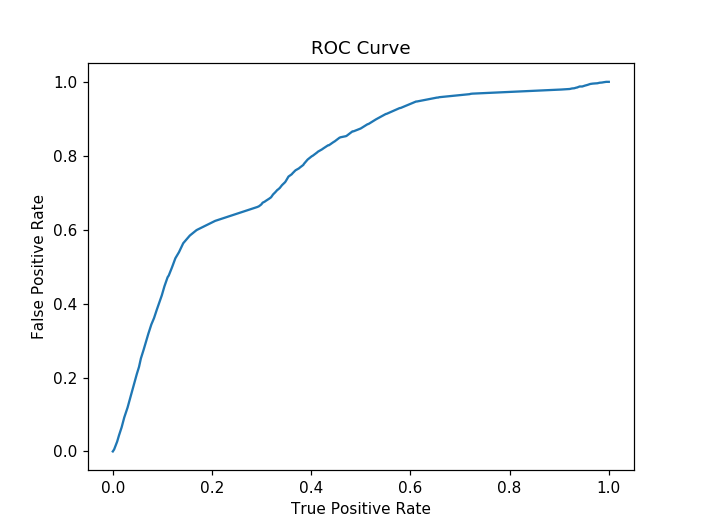

Training set areaUnderROC: 0.7786034833302665


In [57]:
trainingSummary = model_lr.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

## DT

In [58]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="TARGET", featuresCol="SelectedFeatures")
dtModel = dt.fit(train)

In [59]:
predict_train=dtModel.transform(train)
predict_valid=dtModel.transform(valid)
#predict_test.select("TARGET","prediction").show(10)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='TARGET')
predict_valid.select("TARGET","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_valid)))

+------+----------------+----------+--------------------+
|TARGET|   rawPrediction|prediction|         probability|
+------+----------------+----------+--------------------+
|     0|[51035.0,2068.0]|       0.0|[0.96105681411596...|
|     0|[51035.0,2068.0]|       0.0|[0.96105681411596...|
|     0|[51035.0,2068.0]|       0.0|[0.96105681411596...|
|     0|[51035.0,2068.0]|       0.0|[0.96105681411596...|
|     0|[51035.0,2068.0]|       0.0|[0.96105681411596...|
+------+----------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.5
The area under ROC for test set is 0.5


## GBT

In [62]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="TARGET", featuresCol="SelectedFeatures", maxIter=10)




# Train model.  This also runs the indexers.
gbt_model = gbt.fit(train)

# Make predictions.
gbt_predictions = gbt_model.transform(valid)

# Select example rows to display.
#gbt_predictions.select('ID', 'TARGET', 'rawPrediction', 'prediction', 'probability').show(5)


predict_train=gbt_model.transform(train)
predict_valid=gbt_model.transform(valid)
#predict_test.select("TARGET","prediction").show(10)



from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='TARGET')
predict_valid.select("TARGET","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_valid)))

+------+--------------------+----------+--------------------+
|TARGET|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     0|[1.30002527710391...|       0.0|[0.93086483316861...|
|     0|[1.30169941656555...|       0.0|[0.93108000270136...|
|     0|[1.19764872069933...|       0.0|[0.91646800628834...|
|     0|[1.28741019030569...|       0.0|[0.92922337597352...|
|     0|[1.20607541516156...|       0.0|[0.91774918457720...|
+------+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.8124819760929419
The area under ROC for test set is 0.7373327918258835


### RandomForest

In [68]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="TARGET", featuresCol="SelectedFeatures", numTrees=60 )


mode_rf = rf.fit(train)

predict_train=mode_rf.transform(train)
predict_valid=mode_rf.transform(valid)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='TARGET')
predict_valid.select("TARGET","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_valid)))

+------+--------------------+----------+--------------------+
|TARGET|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     0|[57.6691888124578...|       0.0|[0.96115314687429...|
|     0|[56.8386392187120...|       0.0|[0.94731065364520...|
|     0|[57.4964963943065...|       0.0|[0.95827493990510...|
|     0|[57.9979412723217...|       0.0|[0.96663235453869...|
|     0|[55.7327945017832...|       0.0|[0.92887990836305...|
+------+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.7870789881560023
The area under ROC for test set is 0.7741869885247539


### LinearSVC

In [64]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1, featuresCol='SelectedFeatures'  ,labelCol='TARGET')

mode_lsvc = lsvc.fit(train)

predict_train=mode_lsvc.transform(train)
predict_valid=mode_lsvc.transform(valid)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='TARGET')
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_valid)))


The area under ROC for train set is 0.32610833408028306
The area under ROC for test set is 0.521835327842745


## Hyperparameter for Random Forest

In [81]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [70]:
rf = RandomForestClassifier(labelCol="TARGET", featuresCol="SelectedFeatures" )


In [111]:
paramGrid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [5, 10 ]) \
    .addGrid(rf.numTrees, [10, 60,]).build()
#     .addGrid(rf.maxBins, [32, 64])\
#    .build()

In [112]:
tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='TARGET'),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

In [113]:
tvs_model = tvs.fit(train)


In [156]:
np.mean(tvs_model.validationMetrics)

0.7813197405004635

In [127]:
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 60,]) \
    .addGrid(rf.maxDepth, [5, 10 ]).build()
#     .addGrid(rf.numTrees, [10, 60,]).build()
#     .addGrid(rf.maxBins, [32, 64])\
#    .build()

In [128]:
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='TARGET'),
                          numFolds=3)  # use 3+ folds in practice

In [129]:
mode_rf_tunning_crossval = crossval.fit(train)



In [155]:
np.mean(mode_rf_tunning_crossval.avgMetrics)

0.7835471795761585

In [157]:
mode_rf_tunning_crossval.bestModel

RandomForestClassificationModel (uid=RandomForestClassifier_bb8ac972ec9c) with 60 trees